In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [9]:
def load_stock_data(filepath):
    """Loads stock data, parses dates, and sets Date as index."""
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])  # Convert Date column to datetime
    df.set_index('Date', inplace=True)  # Set Date as index
    return df

In [10]:
def create_sequences(data, target, seq_length=10):
    """Creates input sequences for CNN + LSTM."""
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i+seq_length])
        y_seq.append(target[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

In [ ]:
def train_cnn_lstm(stock_name, seq_length=10):
    """Trains CNN + LSTM for a given stock."""
    
    print(f"\nTraining CNN + LSTM for {stock_name.upper()}\n")

    # Load Data
    file_path = f"../data/{stock_name}_stock_features_selected.csv"
    df = load_stock_data(file_path)

    # Target Variable: Close Price
    y = df[['Close']].values  
    X = df.drop(columns=['Close'])  

    # Split Data (
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Scale Data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    # Prepare Data for CNN + LSTM
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_length)

    # Reshape for CNN
    X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], seq_length, X_train_seq.shape[2])
    X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], seq_length, X_test_seq.shape[2])

    # Build CNN + LSTM Model
    model = Sequential([
        # Convolutional Layers
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, X_train_seq.shape[2])),
        MaxPooling1D(pool_size=2),
        
        # LSTM Layers
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(32)),
        Dropout(0.1),
        
        # Output Layer
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')

    # Callbacks for Performance Optimization
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

    # Train CNN + LSTM
    history = model.fit(X_train_seq, y_train_seq, 
                        epochs=50, batch_size=16, 
                        validation_data=(X_test_seq, y_test_seq), 
                        verbose=1, callbacks=[reduce_lr, early_stopping])

    # Evaluate & Compare
    y_pred_cnn_lstm = model.predict(X_test_seq)
    y_pred_cnn_lstm = scaler_y.inverse_transform(y_pred_cnn_lstm)

    y_test_actual = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

    mse = tf.keras.losses.MeanSquaredError()(y_test_actual, y_pred_cnn_lstm).numpy()
    r2 = 1 - (np.sum((y_test_actual-y_pred_cnn_lstm)**2)/np.sum((y_test_actual - np.mean(y_test_actual))**2))

    print(f"MSE: {mse:.5f}, R2: {r2:.5f}")
    

    # Plot Results
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_actual, label="Actual Close Price", color='blue')
    plt.plot(y_pred_cnn_lstm, label="CNN + LSTM Prediction", color='red')
    plt.legend()
    plt.title(f"{stock_name.upper()} Stock Price Prediction: CNN + LSTM Model")
    plt.show()

    return model, history


Training CNN + LSTM for NVIDIA

Epoch 1/50
318/318 [==============================] - 12s 21ms/step - loss: 0.0016 - val_loss: 48.3981 - lr: 0.0010
Epoch 2/50
318/318 [==============================] - 5s 16ms/step - loss: 8.4274e-04 - val_loss: 47.6184 - lr: 0.0010
Epoch 3/50
318/318 [==============================] - 5s 16ms/step - loss: 6.5429e-04 - val_loss: 47.2228 - lr: 0.0010
Epoch 4/50
318/318 [==============================] - 5s 16ms/step - loss: 5.0594e-04 - val_loss: 46.5634 - lr: 0.0010
Epoch 5/50
318/318 [==============================] - 5s 16ms/step - loss: 5.5368e-04 - val_loss: 47.5288 - lr: 0.0010
Epoch 6/50
318/318 [==============================] - 5s 16ms/step - loss: 4.9294e-04 - val_loss: 47.5059 - lr: 0.0010
Epoch 7/50
318/318 [==============================] - 5s 16ms/step - loss: 4.6743e-04 - val_loss: 47.5684 - lr: 0.0010
Epoch 8/50
318/318 [==============================] - 5s 15ms/step - loss: 5.0203e-04 - val_loss: 48.4438 - lr: 0.0010
Epoch 9/50
317/318

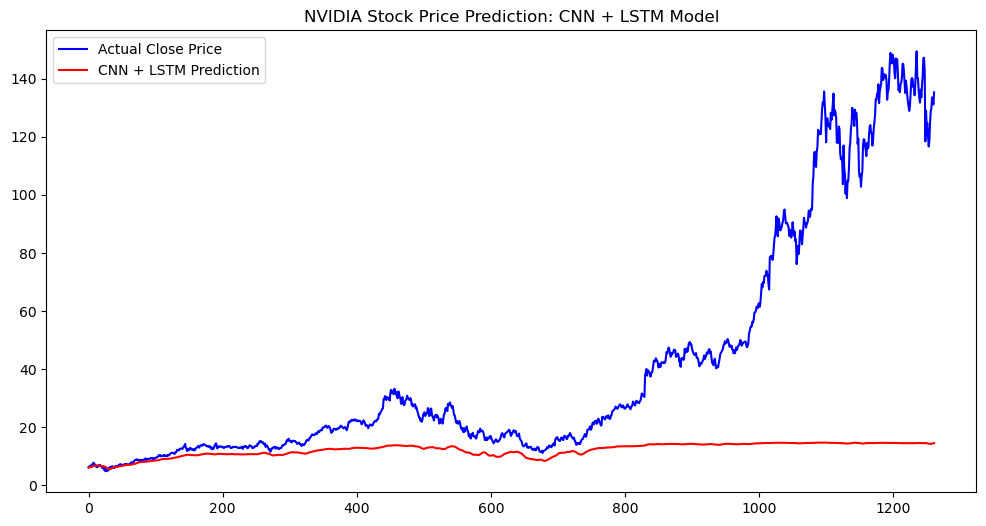

(<keras.engine.sequential.Sequential at 0x2cabbaaf4f0>,
 <keras.callbacks.History at 0x2cac53d0a60>)

In [12]:
train_cnn_lstm("nvidia")


Training CNN + LSTM for APPLE

Epoch 1/50
547/547 [==============================] - 15s 19ms/step - loss: 9.3947e-04 - val_loss: 6.8707 - lr: 0.0010
Epoch 2/50
547/547 [==============================] - 8s 15ms/step - loss: 6.8417e-04 - val_loss: 8.5814 - lr: 0.0010
Epoch 3/50
547/547 [==============================] - 9s 16ms/step - loss: 5.4893e-04 - val_loss: 9.4104 - lr: 0.0010
Epoch 4/50
547/547 [==============================] - 8s 15ms/step - loss: 3.8921e-04 - val_loss: 8.7616 - lr: 0.0010
Epoch 5/50
547/547 [==============================] - 9s 16ms/step - loss: 3.8754e-04 - val_loss: 8.5907 - lr: 0.0010
Epoch 6/50
546/547 [============================>.] - ETA: 0s - loss: 3.7921e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
547/547 [==============================] - 8s 15ms/step - loss: 3.7914e-04 - val_loss: 9.0672 - lr: 0.0010
Epoch 7/50
547/547 [==============================] - 8s 15ms/step - loss: 2.8937e-04 - val_loss: 8.8607 - lr: 5.

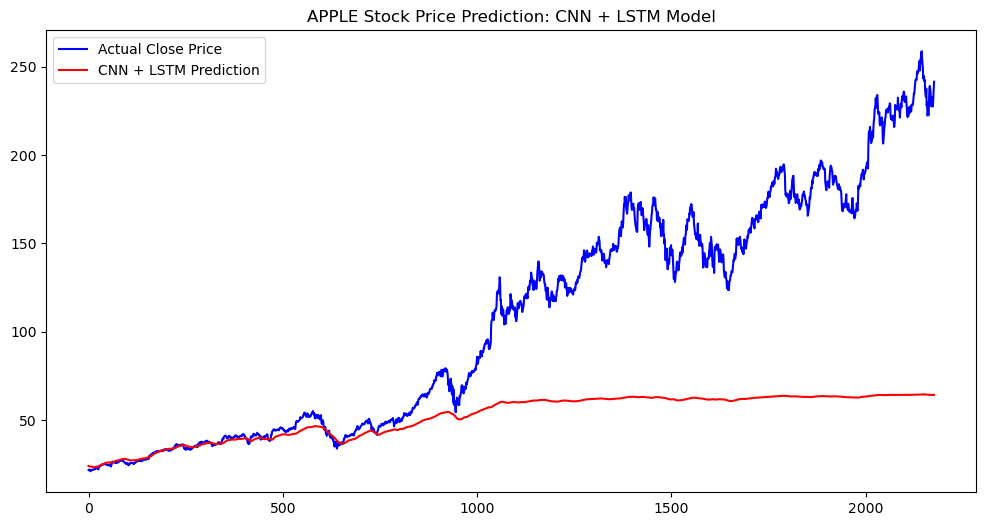

(<keras.engine.sequential.Sequential at 0x2cabbb380d0>,
 <keras.callbacks.History at 0x2cac3ab3f70>)

In [13]:
train_cnn_lstm("apple")


Training CNN + LSTM for MICROSOFT

Epoch 1/50
480/480 [==============================] - 14s 18ms/step - loss: 0.0018 - val_loss: 3.3752 - lr: 0.0010
Epoch 2/50
480/480 [==============================] - 7s 15ms/step - loss: 5.4467e-04 - val_loss: 3.8233 - lr: 0.0010
Epoch 3/50
480/480 [==============================] - 8s 16ms/step - loss: 4.5120e-04 - val_loss: 4.2859 - lr: 0.0010
Epoch 4/50
480/480 [==============================] - 8s 16ms/step - loss: 4.3736e-04 - val_loss: 4.4308 - lr: 0.0010
Epoch 5/50
480/480 [==============================] - 7s 16ms/step - loss: 4.2504e-04 - val_loss: 4.4334 - lr: 0.0010
Epoch 6/50
477/480 [============================>.] - ETA: 0s - loss: 4.0073e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
480/480 [==============================] - 8s 16ms/step - loss: 4.0366e-04 - val_loss: 5.0221 - lr: 0.0010
Epoch 7/50
480/480 [==============================] - 7s 15ms/step - loss: 2.7682e-04 - val_loss: 5.1700 - lr: 5.

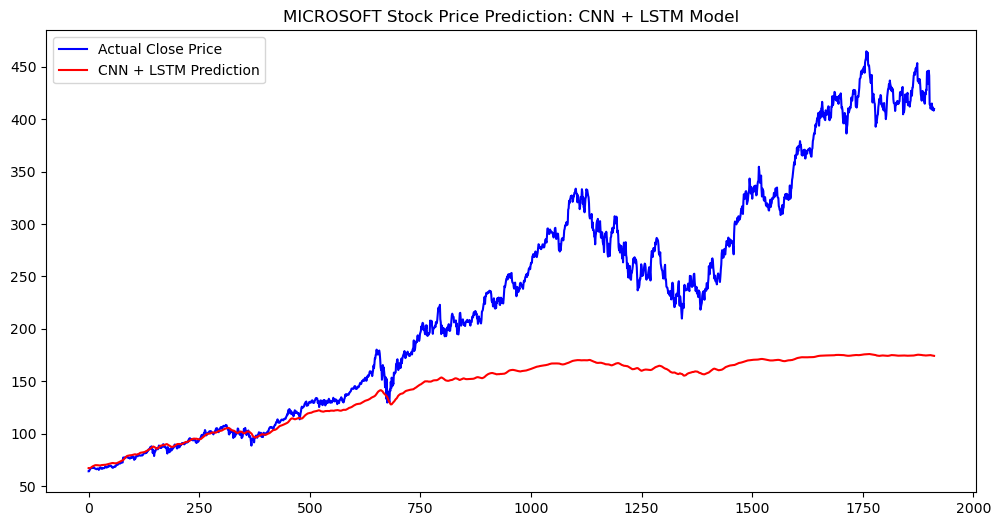

(<keras.engine.sequential.Sequential at 0x2cac3402160>,
 <keras.callbacks.History at 0x2cac37229d0>)

In [14]:
train_cnn_lstm("microsoft")

1. Poor Predictions in All Stocks
- Predicted values (red line) are significantly lower than actual values (blue line).
- The model fails to capture stock price trends and volatility, suggesting severe underfitting.

2. High Validation Loss and Poor Generalization
- The validation loss remains high despite learning rate reductions, indicating the model is struggling to learn meaningful patterns.
- NVIDIA: Val loss ~47, MSE = 2356.94, R² = -0.44 (very poor fit)
- Apple: Val loss ~8.6, MSE = 6054.70, R² = -0.42 (very poor fit)
- Microsoft: Val loss ~4.9, MSE = 14821.57, R² = -0.16 (still bad, but slightly better)

3. Overfitting to Training Data
- Training loss is extremely low (~0.0003 - 0.0016), but validation loss remains high.
- Indicates the model is learning the training data well but failing to generalize to unseen data.

In [15]:
def custom_weighted_loss(y_true, y_pred):
    weights = tf.range(1, tf.shape(y_true)[0] + 1, dtype=tf.float32)
    weights = tf.math.exp(weights / tf.reduce_max(weights))
    mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
    loss = mse(y_true, y_pred)
    return tf.reduce_mean(loss * weights)

In [ ]:
def custom_cnn_lstm(stock_name, seq_length=10):
    """Trains CNN + LSTM for a given stock."""
    
    print(f"\nTraining CNN + LSTM for {stock_name.upper()} with Custom Loss Function\n")

    # Load Data
    file_path = f"../data/{stock_name}_stock_features_selected.csv"
    df = load_stock_data(file_path)

    # Target Variable
    y = df[['Close']].values  
    X = df.drop(columns=['Close'])  

    # Split Data 
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Scale Data 
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    # Prepare Data for CNN + LSTM

    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_length)

    X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], seq_length, X_train_seq.shape[2])
    X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], seq_length, X_test_seq.shape[2])

    # Build CNN + LSTM Model
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, X_train_seq.shape[2])),
        MaxPooling1D(pool_size=2),
        
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(50)),
        Dropout(0.2),
        Dense(units=25),
        Dense(units=1)
    ])

    model.compile(optimizer='adam', loss=custom_weighted_loss)

    # Callbacks for Performance Optimization
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-5)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

    # Train CNN + LSTM
    history = model.fit(X_train_seq, y_train_seq, 
                        epochs=50, batch_size=16, 
                        validation_data=(X_test_seq, y_test_seq), 
                        verbose=1, callbacks=[reduce_lr, early_stopping])

    # Evaluate & Compare
    y_pred_cnn_lstm = model.predict(X_test_seq)
    y_pred_cnn_lstm = scaler_y.inverse_transform(y_pred_cnn_lstm)

    y_test_actual = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

    mse = tf.keras.losses.MeanSquaredError()(y_test_actual, y_pred_cnn_lstm).numpy()
    r2 = 1 - (np.sum((y_test_actual-y_pred_cnn_lstm)**2)/np.sum((y_test_actual - np.mean(y_test_actual))**2))

    print(f"MSE: {mse:.5f}, R2: {r2:.5f}")

    # Plot Results
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_actual, label="Actual Close Price", color='blue')
    plt.plot(y_pred_cnn_lstm, label="CNN + LSTM Prediction", color='red')
    plt.legend()
    plt.title(f"{stock_name.upper()} Stock Price Prediction: CNN + LSTM Model with Custom Loss")
    plt.show()

    return model, history


Training CNN + LSTM for NVIDIA with Custom Loss Function

Epoch 1/50
318/318 [==============================] - 12s 21ms/step - loss: 0.0035 - val_loss: 80.6162 - lr: 0.0010
Epoch 2/50
318/318 [==============================] - 6s 18ms/step - loss: 0.0020 - val_loss: 87.2427 - lr: 0.0010
Epoch 3/50
318/318 [==============================] - 5s 17ms/step - loss: 0.0013 - val_loss: 85.6768 - lr: 0.0010
Epoch 4/50
318/318 [==============================] - 6s 17ms/step - loss: 0.0013 - val_loss: 87.1181 - lr: 0.0010
Epoch 5/50
318/318 [==============================] - 6s 17ms/step - loss: 0.0012 - val_loss: 83.4211 - lr: 0.0010
Epoch 6/50
316/318 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
318/318 [==============================] - 6s 18ms/step - loss: 0.0010 - val_loss: 81.2881 - lr: 0.0010
Epoch 7/50
318/318 [==============================] - 6s 18ms/step - loss: 8.7395e-04 - val_loss: 83.7006 - 

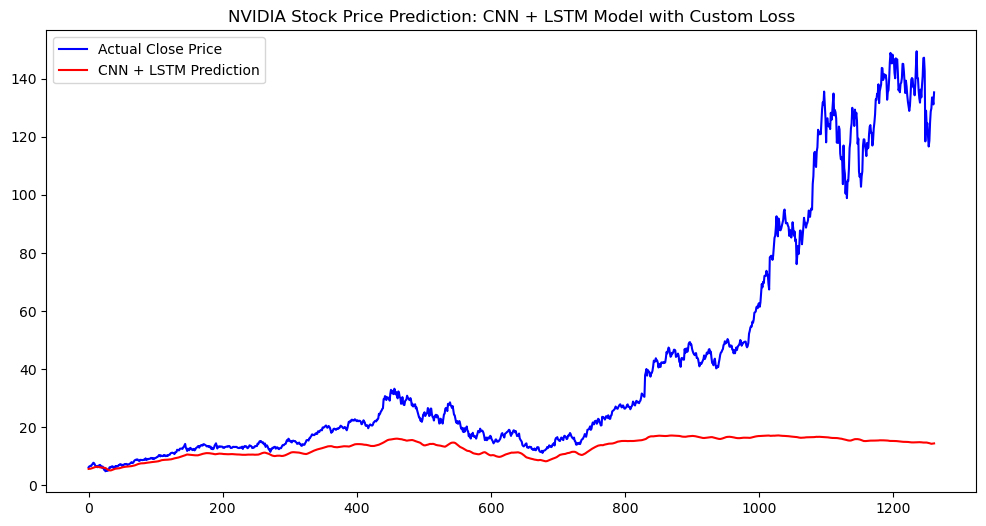

(<keras.engine.sequential.Sequential at 0x2caf66212e0>,
 <keras.callbacks.History at 0x2cb003abe50>)

In [19]:
custom_cnn_lstm('nvidia')


Training CNN + LSTM for APPLE with Custom Loss Function

Epoch 1/50
547/547 [==============================] - 19s 23ms/step - loss: 0.0026 - val_loss: 14.1629 - lr: 0.0010
Epoch 2/50
547/547 [==============================] - 10s 18ms/step - loss: 0.0014 - val_loss: 12.3563 - lr: 0.0010
Epoch 3/50
547/547 [==============================] - 10s 18ms/step - loss: 0.0011 - val_loss: 14.6424 - lr: 0.0010
Epoch 4/50
547/547 [==============================] - 10s 19ms/step - loss: 0.0011 - val_loss: 13.1100 - lr: 0.0010
Epoch 5/50
547/547 [==============================] - 10s 18ms/step - loss: 9.4154e-04 - val_loss: 13.2384 - lr: 0.0010
Epoch 6/50
547/547 [==============================] - 10s 18ms/step - loss: 9.3303e-04 - val_loss: 13.2187 - lr: 0.0010
Epoch 7/50
545/547 [============================>.] - ETA: 0s - loss: 9.5670e-04
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
547/547 [==============================] - 10s 18ms/step - loss: 9.5622e-04 - val

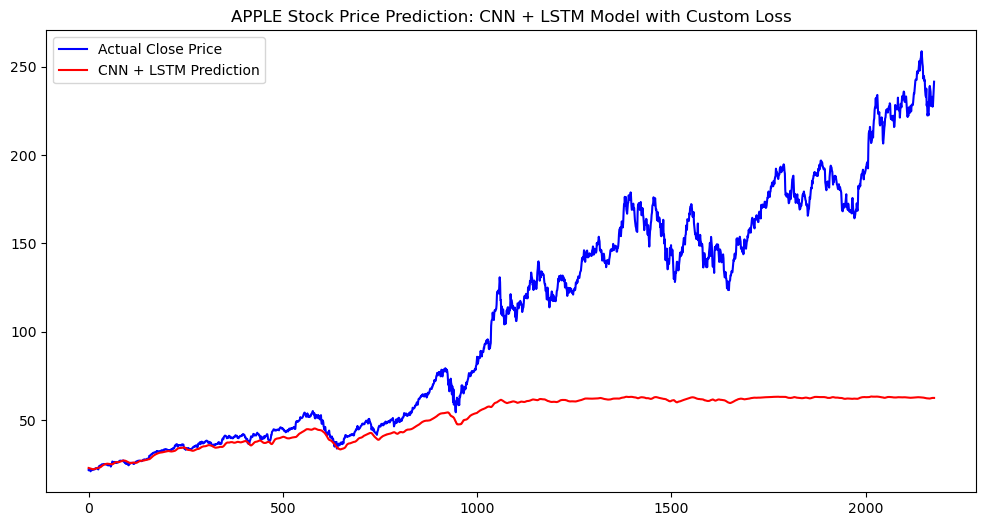

(<keras.engine.sequential.Sequential at 0x2caf698fa30>,
 <keras.callbacks.History at 0x2cb00060a30>)

In [20]:
custom_cnn_lstm('apple')


Training CNN + LSTM for MICROSOFT with Custom Loss Function

Epoch 1/50
480/480 [==============================] - 15s 20ms/step - loss: 0.0038 - val_loss: 5.7419 - lr: 0.0010
Epoch 2/50
480/480 [==============================] - 9s 18ms/step - loss: 0.0010 - val_loss: 4.1332 - lr: 0.0010
Epoch 3/50
480/480 [==============================] - 9s 18ms/step - loss: 9.6848e-04 - val_loss: 4.2148 - lr: 0.0010
Epoch 4/50
480/480 [==============================] - 9s 19ms/step - loss: 7.0490e-04 - val_loss: 4.6189 - lr: 0.0010
Epoch 5/50
480/480 [==============================] - 9s 18ms/step - loss: 5.7347e-04 - val_loss: 4.4829 - lr: 0.0010
Epoch 6/50
480/480 [==============================] - 10s 21ms/step - loss: 5.5925e-04 - val_loss: 5.4653 - lr: 0.0010
Epoch 7/50
479/480 [============================>.] - ETA: 0s - loss: 7.0508e-04
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
480/480 [==============================] - 11s 23ms/step - loss: 7.0451e-04 - v

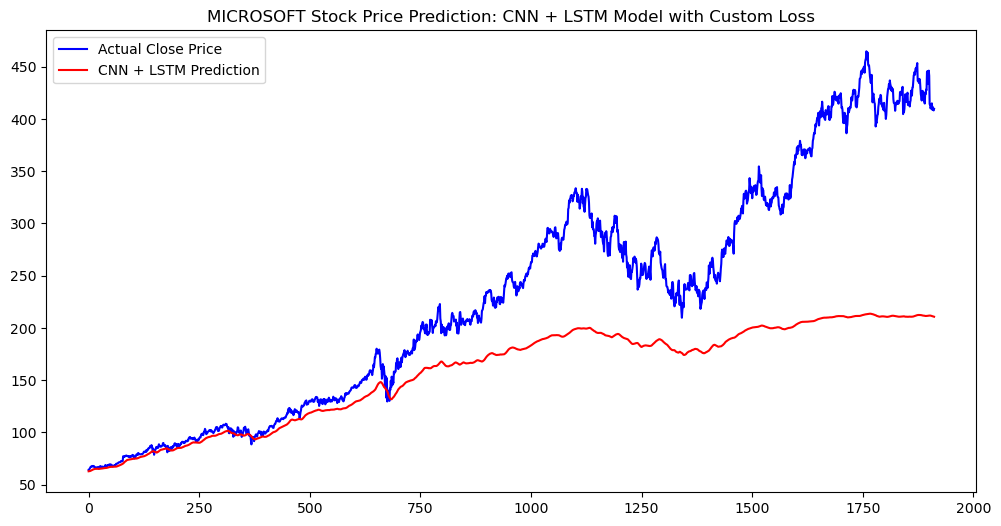

(<keras.engine.sequential.Sequential at 0x2cae6433760>,
 <keras.callbacks.History at 0x2cae6320e50>)

In [21]:
custom_cnn_lstm('microsoft')

1. Key Observations from the Plots
- Predictions (red line) are still significantly lower than actual prices (blue line) for all stocks.
- The model slightly improved for Microsoft and Apple, but NVIDIA's performance worsened compared to the previous attempt.
- The predicted stock prices are less erratic than before, meaning the model may have improved in smoothness but still lacks the ability to follow price fluctuations.

2. Evaluation Metrics Comparison

NVIDIA

- MSE: 2280.17 (previous: 2356.94) → Slight improvement
- R²: -0.3938 (previous: -0.4407) → Still very poor

APPLE

- MSE: 6116.31 (previous: 6054.70) → Worse than before
- R²: -0.4342 (previous: -0.4197) → Worse than before

MICROSOFT

- MSE: 10199.41 (previous: 14821.57) → Significant improvement!
- R²: 0.2012 (previous: -0.1607) → First positive R² value!
- Microsoft saw the biggest improvement, suggesting that the custom loss function helped in capturing trends better.
- Apple and NVIDIA, however, showed no meaningful improvement, with Apple’s performance worsening slightly.

3. Issues with the Model
- The Model Still Underfits the Data
- Predictions remain too low and don’t follow actual trends closely.
- The model struggles with high volatility stocks like NVIDIA.
- Custom Loss Function Doesn’t Fix the Core Issue
- Despite changes, the model fails to predict actual price fluctuations.
- Likely due to poor feature selection or inappropriate architecture.